# Camera calibration
This notebook demonstrates how to measureme the rolling shutter line rate of a camera.

Note that these calculations assume that the white line is rotating clockwise in the image, and that the rolling shutter starts at the top row and goes down through the rows. If you have a different configuration, the easiest way of dealing with this would be to reflect/rotate the image until it matches this assumption.

In [1]:
# If you are using this notebook to measure your own cameras,
# then using matplotlib in notebook mode may be helpful for finding
# coordinates within the images (or you can use VIA or some other
# image editing software). Uncomment the next line if you want to use
# matplotlib for finding the coordinates

#%matplotlib notebook

from itertools import chain
import math

import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from matplotlib import patches

First we will define a few functions which will help for calculating rolling shutter line rate

In [2]:
def get_angle(c, a, b):
    '''
    Get the angle of acb
    '''
    angle_a = np.arctan2(a[1] - c[1], a[0] - c[0])
    angle_b = np.arctan2(b[1] - c[1], b[0] - c[0])
    
    return angle_b - angle_a


def get_linerate(angular_vel, centre, a, b):
    '''
    Get linerate from observations of pixels truning on or off
    '''
    angle = get_angle(centre, a, b)
    time = (angle - np.pi) / angular_vel
    rate = (b[1] - a[1]) / time
    
    return rate


def simulate_rotation(t, linerate, angular_vel, centre, a_0):
    '''
    Get a curve simulating the rotation
    '''
    a_t = angular_vel * t + a_0
    y_t = linerate * t
    x_t = centre[0] + (y_t - centre[1]) / np.tan(a_t)
    
    return x_t, y_t

Next we load the calibration images and plot the various points of interest on them (note you can use `%matplotlib notebook` to enable interactive plots, which can help you find where these points should be). For flexibility on the number of images used, we will define these points in a list of dicts.

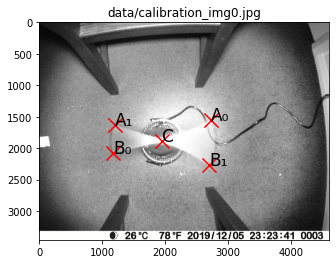

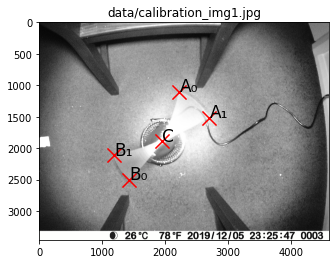

In [3]:
############### Edit this section to use your own data #########################
# Specify image files
calibration_img_files = [
    "data/calibration_img0.jpg",
    "data/calibration_img1.jpg",
]  # Update this list to use your own images

# Specify points of interest
points = [
    {
        "C": (1946, 1881),
        "A0": (2723, 1554),
        "B0": (1174, 2080),
        "A1": (1193, 1628),
        "B1": (2695, 2271),
    },
    {
        "C": (1946, 1881),
        "A0": (2225, 1100),
        "B0": (1429, 2498),
        "A1": (2702, 1514),
        "B1": (1190, 2116),
    },
]  # Update this list to use the points from your own images

# Specify rotational velocity (units are rotations per second)
rot_freqs = [
    3.679,
    3.679,
]  # Update this with your own measurement(s) (can be different for each image)
################################################################################

assert len(points) == len(calibration_img_files), "Must have points definitions for each image"
assert len(rot_freqs) == len(calibration_img_files), "Must have rotation frequency for each image"

# Load images
calibration_imgs = [imread(img_file) for img_file in calibration_img_files]

# Plot images
fontsize = 17
markersize = 200
for i in range(len(calibration_imgs)):
    fig = plt.figure()
    ax = fig.add_subplot(111, title=calibration_img_files[i])
    ax.set_xlim(0, calibration_imgs[i].shape[1])
    ax.set_ylim(calibration_imgs[i].shape[0], 0)
    ax.imshow(calibration_imgs[i])
    ax.scatter(*zip(*points[i].values()), marker='x',c='r', s=markersize)
    ax.annotate("A₀", points[i]["A0"], fontsize=fontsize)
    ax.annotate("B₀", points[i]["B0"], fontsize=fontsize)
    ax.annotate("A₁", points[i]["A1"], fontsize=fontsize)
    ax.annotate("B₁", points[i]["B1"], fontsize=fontsize)
    ax.annotate("C", points[i]["C"], fontsize=fontsize)

Now that we have input our data, we can calculate the rolling shutter line rate

In [4]:
angular_vels = [2 * np.pi * rot_freq for rot_freq in rot_freqs]

on_rates, off_rates = [], []
for i in range(len(calibration_imgs)):
    on_rates.append(get_linerate(
        angular_vels[i],
        points[i]["C"],
        points[i]["A0"],
        points[i]["B0"],
    ))
    off_rates.append(get_linerate(
        angular_vels[i],
        points[i]["C"],
        points[i]["A1"],
        points[i]["B1"],
    ))
    
line_rate = np.mean([on_rates, off_rates])

print("image_file_path \ton_rate \toff_rate")
for i in range(len(calibration_imgs)):
    print(f"{calibration_img_files[i]}\t{on_rates[i]:.2e}\t{off_rates[i]:.2e}")


print(f"\nMean rolling shutter line rate: {line_rate:.2e}")

image_file_path 	on_rate 	off_rate
data/calibration_img0.jpg	8.32e+04	9.53e+04
data/calibration_img1.jpg	9.12e+04	9.24e+04

Mean rolling shutter line rate: 9.05e+04


To assess the quality of this measurement, we can simulate the effect of rolling shutter, and see how well it mateches the entirety of the images. The following cell runs this simulation.

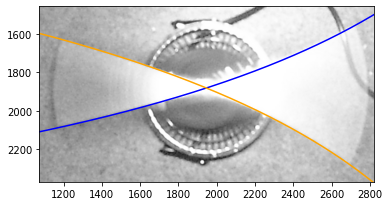

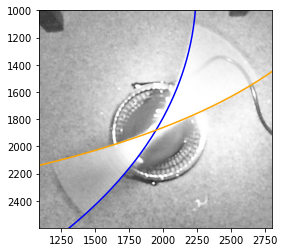

In [5]:
# Define an independent variable (time) for the simulation
t = np.linspace(1 / line_rate, calibration_imgs[0].shape[0] / line_rate, num=1000)

for i in range(len(calibration_imgs)):
    # Calculate the time at A0 (start of exposure)
    time_A0 = points[i]["A0"][1] / line_rate
    # Calculate the angle of the white line at start of exposure at A0
    angle_A0 = np.arctan2(
        points[i]["A0"][1] - points[i]["C"][1],
        points[i]["A0"][0] - points[i]["C"][0],
    )
    # Calculate the angle of the white line at t = 0
    angle_t0_A0 = angle_A0 - angular_vels[i] * time_A0
    
    # Calculate the time at A1 (end of exposure)
    time_A1 = points[i]["A1"][1] / line_rate
    # Calculate the angle of the white line at end of exposure at A1
    angle_A1 = np.arctan2(
        points[i]["A1"][1] - points[i]["C"][1],
        points[i]["A1"][0] - points[i]["C"][0],
    )
    angle_t0_A1 = angle_A1 - angular_vels[i] * time_A1
    
    x_on, y_on = simulate_rotation(t, line_rate, angular_vels[i], points[i]["C"], angle_t0_A0)
    x_off, y_off = simulate_rotation(t, line_rate, angular_vels[i], points[i]["C"], angle_t0_A1)
    
    fig = plt.figure()
    ax= fig.add_subplot(111)
    ax.set_xlim(min([xy[0] for xy in points[i].values()]) - 100, max([xy[0] for xy in points[i].values()]) + 100)
    ax.set_ylim(max([xy[1] for xy in points[i].values()]) + 100, min([xy[1] for xy in points[i].values()]) - 100)
    ax.imshow(calibration_imgs[i])
    ax.plot(x_on, y_on, 'b')
    ax.plot(x_off, y_off, 'orange')

The blue curve indicates where the rotating line was when the exposure turned on and the orange curve shows where the line was when the exposure turned off. These curves should match the edges of the motion blur traced by the rotating line closely. In our example, we see that this worked very well.

Once satisfied that your measurement is accurate, you can proceed onto the other analysis steps.

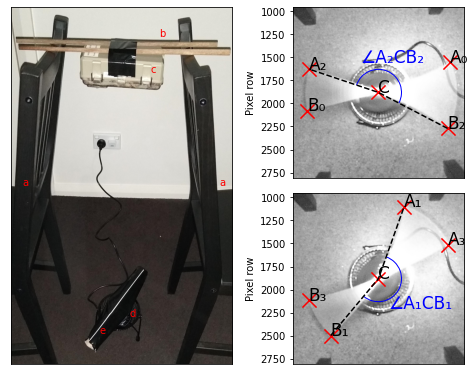

In [6]:
fig_width = 180  # mm
fig_width /= 25.4  # inches
fig_height = fig_width * 3 / 4

# Calculate cropping limits
d_scale = 1.1
d = 0

centre = points[0]["C"]

for p in chain.from_iterable(point_dict.values() for point_dict in points):
    d_pE = (p[0] - centre[0]) ** 2 + (p[1] - centre[1]) ** 2
    d = max(d, d_pE)
d = math.sqrt(d) * d_scale

xlim = (centre[0] - d, centre[0] + d)
ylim = (centre[1] + d, centre[1] - d)

# Plot figure
fig = plt.figure(
    figsize=(fig_width, fig_height),
    tight_layout=True,
)

fontsize = 17
markersize = 200
point_names = [
    {
        "C": "C",
        "A0": "A₀",
        "B0": "B₀",
        "A1": "A₂",
        "B1": "B₂",
    },
    {
        "C": "C",
        "A0": "A₁",
        "B0": "B₁",
        "A1": "A₃",
        "B1": "B₃",
    },
]

for i in range(2):
    ax = fig.add_subplot(222 + i * 2, xlim=xlim, ylim=ylim, ylabel="Pixel row")
    ax.imshow(calibration_imgs[i])
    ax.scatter(*zip(*points[i].values()), marker='x',c='r', s=markersize)
    ax.annotate(point_names[i]["B0"], points[i]["B0"], fontsize=fontsize)
    ax.annotate(point_names[i]["A1"], points[i]["A1"], fontsize=fontsize)
    ax.annotate(point_names[i]["A0"], points[i]["A0"], fontsize=fontsize)
    ax.annotate(point_names[i]["B1"], points[i]["B1"], fontsize=fontsize)
    ax.annotate("C", points[i]["C"], fontsize=fontsize)
    ax.plot(*zip(
        points[i][f"B{1 - i}"],
        points[i]["C"],
        points[i][f"A{1 - i}"]
    ), c='k', linestyle="dashed")

    arc_r = 500

    arc = patches.Arc(
        points[0]["C"],
        arc_r,
        arc_r,
        theta2=(180 / np.pi) * np.arctan2(
            points[i][f"B{1 - i}"][1] - points[i]["C"][1],
            points[i][f"B{1 - i}"][0] - points[i]["C"][0]
        ),
        theta1=(180 / np.pi) * np.arctan2(
            points[i][f"A{1 - i}"][1] - points[i]["C"][1],
            points[i][f"A{1 - i}"][0] - points[i]["C"][0]
        ),
        color="b",
    )
    ax.add_patch(arc)
    ax.annotate(
        ["∠A₂CB₂", "∠A₁CB₁"][i],
        [(2100, 1400), (2400, 2050)][i],
        fontsize=fontsize,
        verticalalignment="top",
        horizontalalignment="center",
        color="b",
    )
    ax.set_xticks([])
#ax0.set_yticks([])


calibration_setup_img = imread("data/calibration_setup.jpg")
ax3 = fig.add_subplot(121)
ax3.imshow(calibration_setup_img)

ax3.annotate("a", (100, 1500), c="r")
ax3.annotate("a", (1750, 1500), c="r")
ax3.annotate("b", (1250, 250), c="r")
ax3.annotate("c", (1175, 550), c="r")
ax3.annotate("d", (1000, 2600), c="r")
ax3.annotate("e", (750, 2750), c="r")

ax3.set_xticks([])
_ = ax3.set_yticks([])

In [7]:
fig.savefig("rolling_shutter_calibration.pdf", dpi=600.0, pad_inches=0.0)